In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, copy, warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
info_raw = pd.read_csv("data/inverse/info.csv")
ccba_raw = pd.read_csv("data/inverse/ccba.csv")
cdtx_raw = pd.read_csv("data/inverse/cdtx.csv")
dp_raw = pd.read_csv("data/inverse/dp.csv")
remit_raw = pd.read_csv("data/inverse/remit.csv")

In [3]:
train = info_raw[~info_raw["sar_flag"].isnull()]
test = info_raw[info_raw["sar_flag"].isnull()]
print(f"info共有 {len(info_raw)} 筆資料 (train: {len(train)}, test: {len(test)})\n")

train_id = train["cust_id"]
test_id = test["cust_id"]
total_id = info_raw["cust_id"].nunique()
print(f"info共有 {total_id} 個id")
print(f"train, test共有 {len(set(train_id) & set(test_id))} 個id交集\n")

sar1_raw = train.query("sar_flag == 1")["cust_id"]
sar0_raw = train.query("sar_flag == 0")["cust_id"]
print(f"SAR同時有 1 和 0 的id有 {len(set(sar1_raw) & set(sar0_raw))} 個\n")

print(f"SAR為1的樣本有 {len(sar1_raw)} 個")
print(f"SAR為0的樣本有 {len(sar0_raw)} 個\n")

print(f"SAR為 1 超過一次的id有 {sum(sar1_raw.value_counts() != 1)} 個")

info共有 25751 筆資料 (train: 23906, test: 1845)

info共有 7708 個id
train, test共有 291 個id交集

SAR同時有 1 和 0 的id有 57 個

SAR為1的樣本有 234 個
SAR為0的樣本有 23672 個

SAR為 1 超過一次的id有 1 個


## Groupby id

In [4]:
source = {
    "ccba": 0,
    "cdtx": 1,
    "dp": 2,
    "remit": 3,
    "info": 4
}

In [5]:
# 依日期排序，刪除日期為空值的data 
date_null = cdtx_raw[cdtx_raw["date"].isnull()].index.to_list()
cdtx_raw = cdtx_raw.drop(date_null).reset_index(drop = True)

date_null = dp_raw[dp_raw["tx_date"].isnull()].index.to_list()
dp_raw = dp_raw.drop(date_null).reset_index(drop = True)

In [6]:
cust_id = {k: i for i, k in enumerate(info_raw["cust_id"].unique())}
data_raw = [[ccba_raw, 0, "byymm"], [cdtx_raw, 1, "date"], [dp_raw, 2, "tx_date"], [remit_raw, 3, "trans_date"], [info_raw, 4, "date"]]

for i in range(len(data_raw)):
    data_raw[i][0]["cust_id"] = data_raw[i][0]["cust_id"].map(cust_id) # label encode
    data_raw[i][0] = data_raw[i][0].rename(columns = {data_raw[i][2]: "date"}) # 統一日期名稱
    data_raw[i][0]["source"] = data_raw[i][1] # 資料源
    data_raw[i][0]["date"] = pd.to_datetime(data_raw[i][0]["date"]) #日期轉換

In [7]:
# 分群
data_g = copy.deepcopy(data_raw)
for df_g in data_g:
    df_g[0] = df_g[0].groupby("cust_id")

In [8]:
# 每個id每個info資料所涵蓋的區間之所有資料
data = {i:{} for i in cust_id.values()}

for id_ in cust_id.values():
    # 抓出id的所有資料
    cust_data1 = []
    for df_g, name, date_col in data_g:
        if id_ in df_g.groups:
            df1 = df_g.get_group(id_)
            cust_data1.extend(df1.to_dict('records'))

    # 依日期、資料源排序
    cust_data1 = sorted(cust_data1, key = lambda X: (X["date"].timestamp(), X["source"]))
    cust_data1 = np.array(cust_data1)

    #抓出各區間的資料
    cust_data2 = {}
    idx = 0
    start = 0
    for i, s in enumerate(cust_data1):
        if s["source"] == 4:
            cust_data2[idx] = {}
            end = i

            if not pd.isnull(cust_data1[end]["sar_flag"]):
                cust_data2[idx]["sar"] = cust_data1[end]["sar_flag"]
                cust_data2[idx]["data_type"] = "train"
            else:
                cust_data2[idx]["data_type"] = "test"


            cust_data2[idx]["data"] = cust_data1[start:end+1]
            start = end + 1
            idx += 1

    data[id_] = cust_data2
    
pickle.dump(data, open('data/inverse/cust_id.pkl', 'wb'))

## Analysis

### Get train data

In [9]:
data = pickle.load(open('data/inverse/cust_id.pkl', 'rb'))

In [10]:
# 所有sample加上sar，並分開各來源的資料
train_g = {0: [], 1: [], 2: [], 3: [], 4: []}
test_g = {0: [], 1: [], 2: [], 3: [], 4: []}

for k1, v1 in data.items():
    for k2, v2 in v1.items():
        if v2["data_type"] == "train":
            sar = v2["sar"]
            for v3 in v2["data"]:
                v3["sar_flag"] = sar
                train_g[v3["source"]].extend([v3])
        else:
            for v3 in v2["data"]:
                test_g[v3["source"]].extend([v3])

In [11]:
for k, v in train_g.items():
    train_g[k] = pd.DataFrame(v)

for k, v in test_g.items():
    test_g[k] = pd.DataFrame(v)

### info 

In [12]:
info = train_g[4].copy()
info = info.drop("source", axis = 1)
null_count = info.isnull().any(axis = 1).sum()
print(f"null: {null_count} / {len(info)} = {round(null_count/len(info), 4)}")
info = info.dropna().reset_index(drop = True)
info.head(3)

null: 116 / 23906 = 0.0049


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171142,2021-04-01,0.0,0,3,12.0,241719.0,3
1,171960,2021-04-06,0.0,0,3,12.0,241719.0,3
2,174802,2021-04-09,0.0,0,3,12.0,241719.0,3


In [13]:
target = "sar_flag"
cat_col = ['risk_rank', 'occupation_code', 'AGE']
num_col = ['total_asset']

In [14]:
info[[target] + cat_col] = info[[target] + cat_col].astype(int)
info1 = info.sort_values(target)
info.head(3)

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171142,2021-04-01,0,0,3,12,241719.0,3
1,171960,2021-04-06,0,0,3,12,241719.0,3
2,174802,2021-04-09,0,0,3,12,241719.0,3


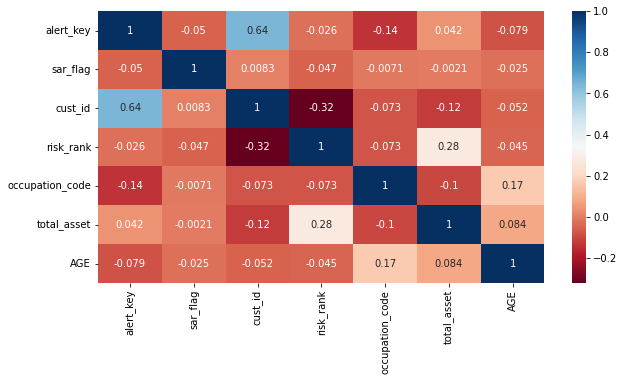

In [15]:
plt.figure(figsize=(10, 5))
corr = info.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()
# TODO:風險和總資產有相關
# TODO:年齡和職業有相關

#### Relationship between features & target

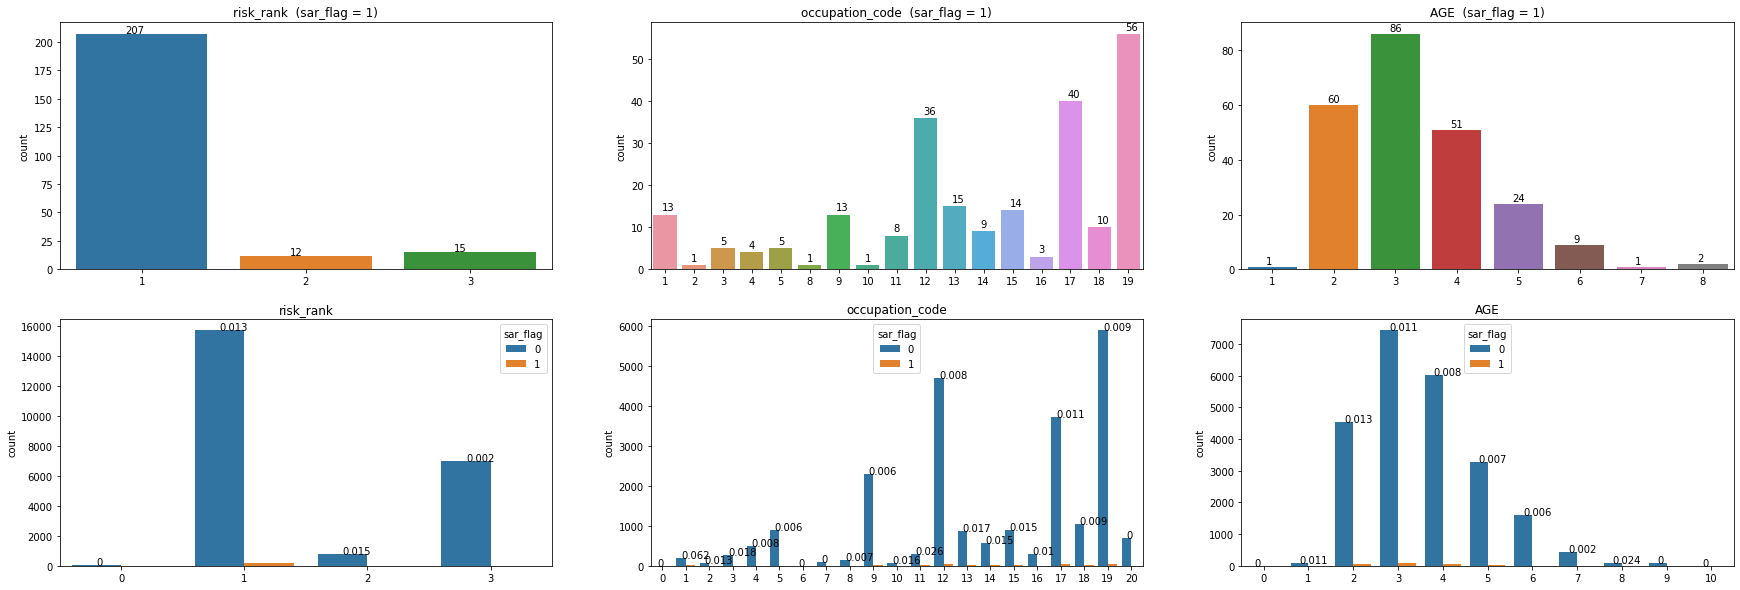

In [16]:
a, b = 2, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for j in range(b):
    sns.countplot(x = cat_col[k], data = info1.query("sar_flag == 1"), ax = ax[0, j])
    sns.countplot(x = cat_col[k], hue = target, data = info1, ax = ax[1, j])

    ax[0, j].set(xlabel = None, title = f"{cat_col[k]}  ({target} = 1)")
    ax[1, j].set(xlabel = None, title = cat_col[k])

    for p in ax[0, j].patches:
        ax[0, j].annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+1), size = 10)
    
    for p in range(0, len(ax[1, j].patches)//2):
        p0 = ax[1, j].patches[p]
        p1 = ax[1, j].patches[p + len(ax[1, j].patches)//2]
        c0 = p0.get_height()
        c1 = p1.get_height()
        prob = round(c1/(c0+c1), 3)
        prob = 0 if pd.isnull(prob) else prob
        ax[1, j].annotate(prob, (p0.get_x()+0.2, p0.get_height()), size = 10)

    k += 1
# TODO:風險高的犯罪機率反而比較低
# TODO:職業1、11的犯罪機率高

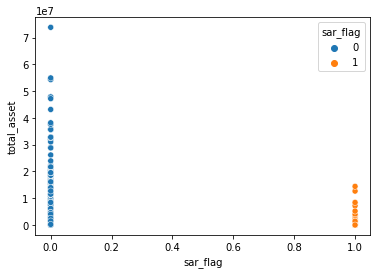

In [17]:
sns.scatterplot(x = target, y = "total_asset", hue = target, data = info1)
plt.show()
# TODO:洗錢帳戶的總資產都不高

#### Relationship between risk_rank & total_asset

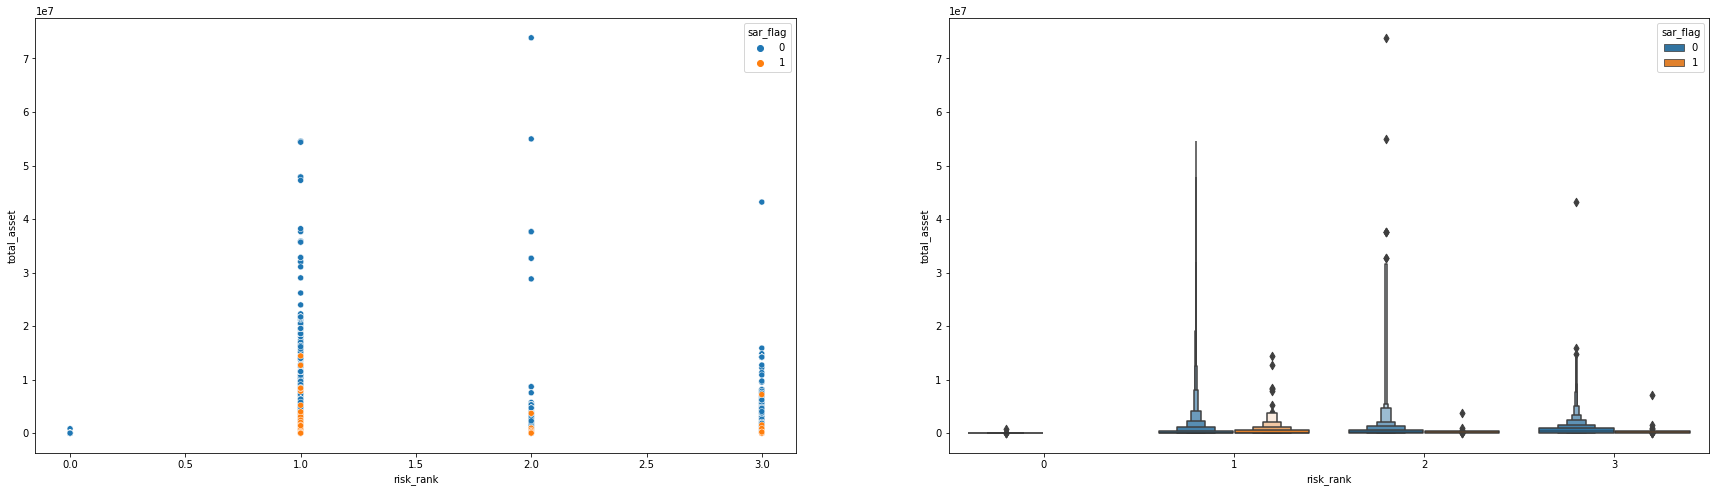

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (30, 8))
sns.scatterplot(x = "risk_rank", y = "total_asset", hue = target, data = info1, ax = ax[0])
sns.boxenplot(x = "risk_rank", y = "total_asset", hue = target, data = info1, ax = ax[1])
plt.show()

#### Relationship between AGE & occupation_code

In [19]:
info2 = info1.copy()
info2["count"] = 1
group = info2.groupby(["AGE", "occupation_code", "sar_flag"])[["count"]].sum()
group = group.reset_index()
group["AGE_OCC"] = list(zip(group["AGE"], group["occupation_code"]))
group = group.sort_values(["sar_flag", "AGE", "occupation_code"], ascending = False)
group1 = group.query("(sar_flag == 1) & (count != 1)")

g = group1["AGE_OCC"]
group0 = group.query("(AGE_OCC in @g) and (sar_flag == 0)")

prob = [i/(i+j) for i, j in zip(group1["count"], group0["count"])]
group1["prob1_0"] = prob

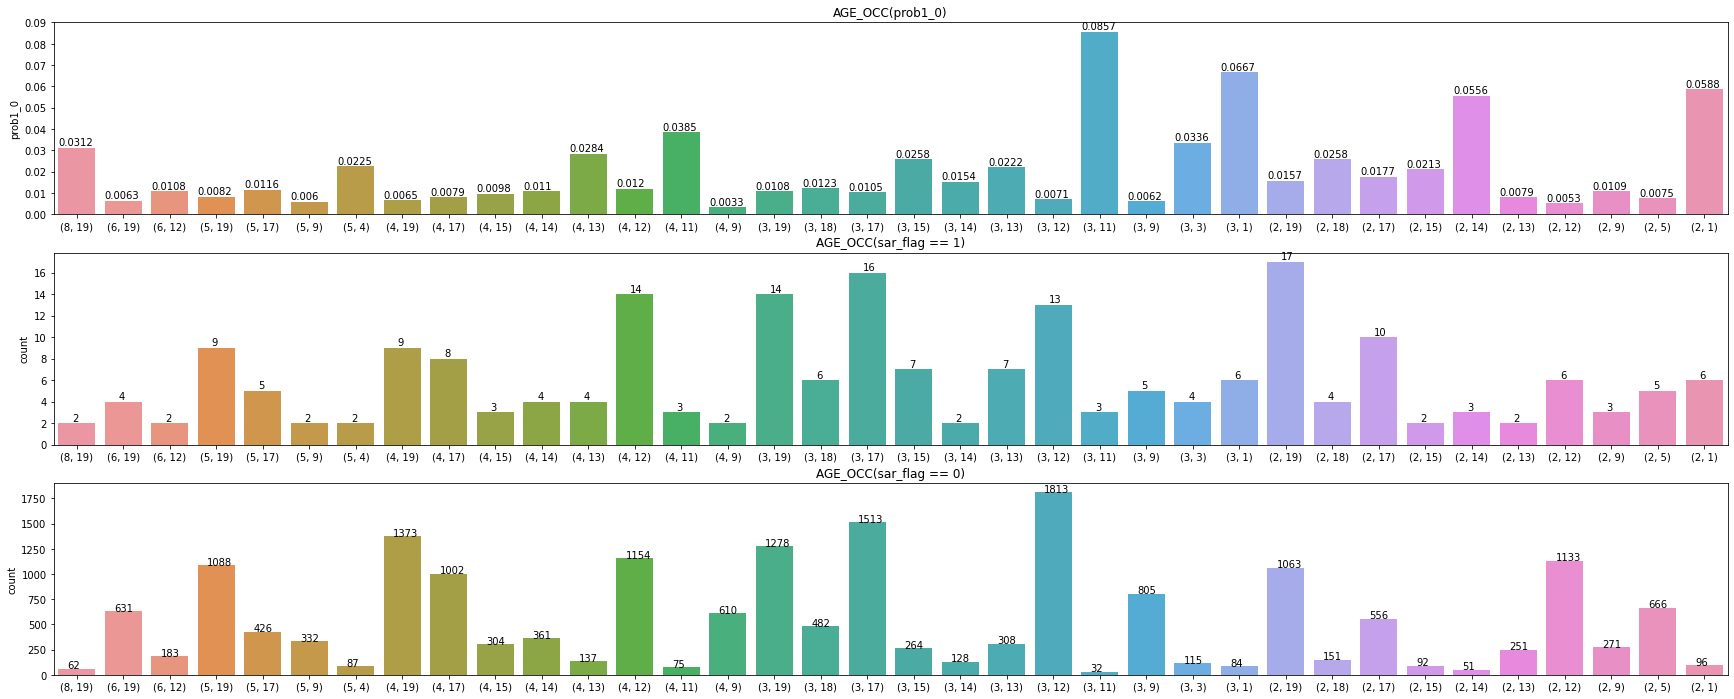

In [20]:
fig, ax = plt.subplots(3, 1, figsize = (30, 12))

sns.barplot(x = "AGE_OCC", y = "prob1_0", data = group1, ax = ax[0])
for p in ax[0].patches:
    ax[0].annotate(f'\n{round(p.get_height(), 4)}', (p.get_x(), p.get_height()+0.001), size=10)
ax[0].set_title("AGE_OCC(prob1_0)")
ax[0].set_xlabel(None)

sns.barplot(x = "AGE_OCC", y = "count", data = group1, ax = ax[1])
for p in ax[1].patches:
    ax[1].annotate(f'\n{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+0.2), size=10)
ax[1].set_title("AGE_OCC(sar_flag == 1)")
ax[1].set_xlabel(None)


sns.barplot(x = "AGE_OCC", y = "count", data = group0, ax = ax[2])
for p in ax[2].patches:
    ax[2].annotate(f'\n{int(p.get_height())}', (p.get_x()+0.2, p.get_height()+2), size=10)
ax[2].set_title("AGE_OCC(sar_flag == 0)")
ax[2].set_xlabel(None)

plt.show()
# TODO:年齡3, 職業11、1；年齡2, 職業14、1的洗錢比例較高

### ccba

In [21]:
ccba = train_g[0].copy()
ccba = ccba.drop("source", axis = 1)
null_count = ccba.isnull().any(axis = 1).sum()
print(f"null: {null_count} / {len(ccba)} = {round(null_count/len(ccba), 4)}")
ccba.head(3)

null: 0 / 22742 = 0.0


,cust_id,lupay,date,cycam,usgam,clamt,csamt,inamt,cucsm,cucah,sar_flag
0,0,12565.0,2021-04-30,150744.0,82748.0,0.0,0.0,12477.0,12477.0,0.0,0.0
1,0,12477.0,2021-05-31,150744.0,78170.0,0.0,0.0,12388.0,12388.0,0.0,0.0
2,0,12388.0,2021-06-30,150744.0,79920.0,0.0,0.0,13316.0,13316.0,0.0,0.0


In [22]:
target = "sar_flag"
num_col = ['lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah']
ccba1 = ccba.sort_values("sar_flag")

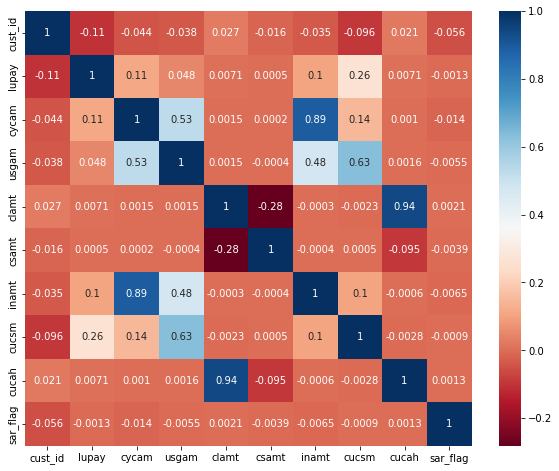

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(data = ccba.corr().round(4), annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

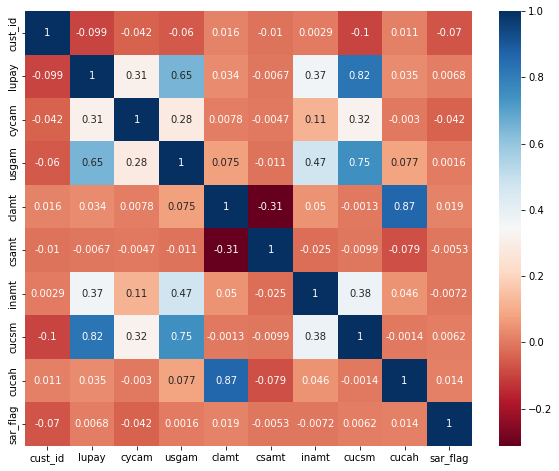

In [24]:
plt.figure(figsize=(10, 8))
corr = ccba.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

#### Relationship between features & target

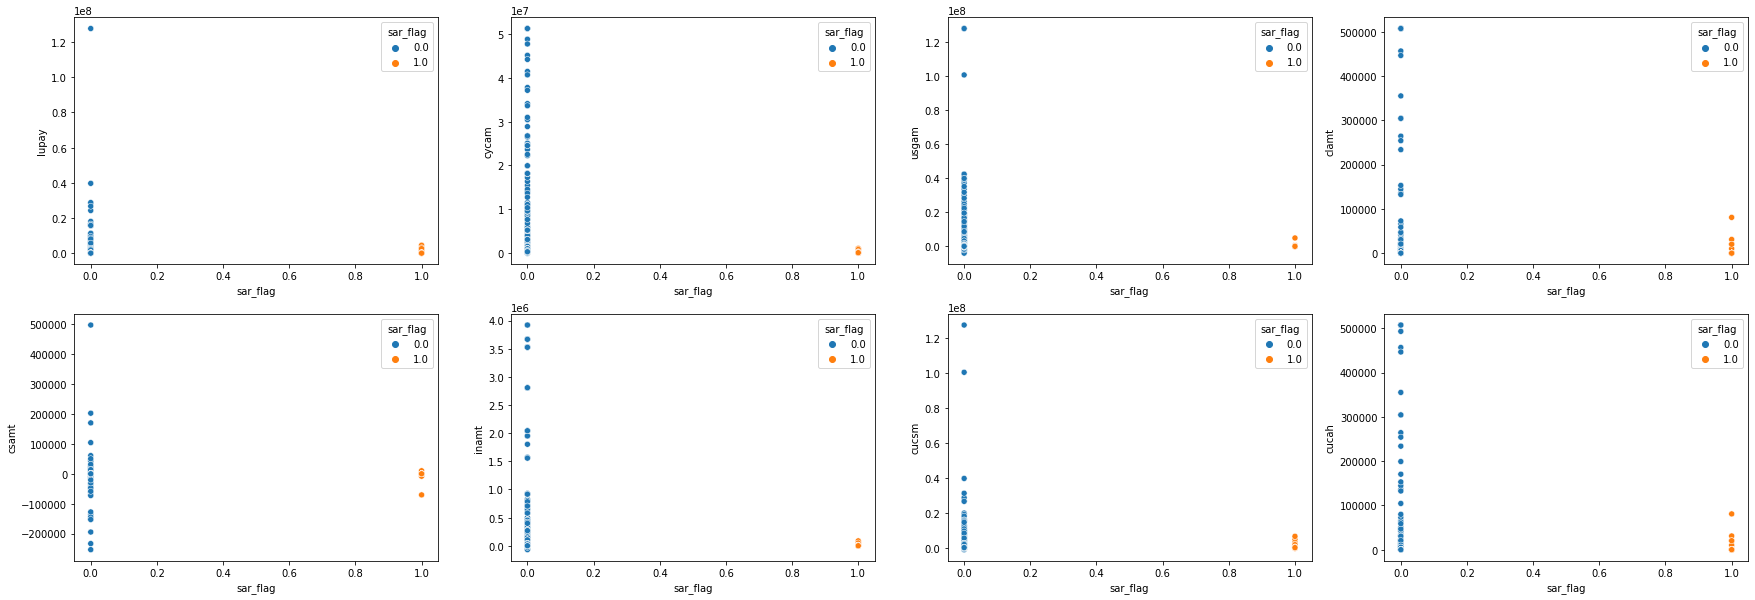

In [25]:
a, b = 2, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.scatterplot(x = target, y = num_col[k], hue = target, data = ccba1, ax = ax[i, j])
        k += 1

#### Relationship between features

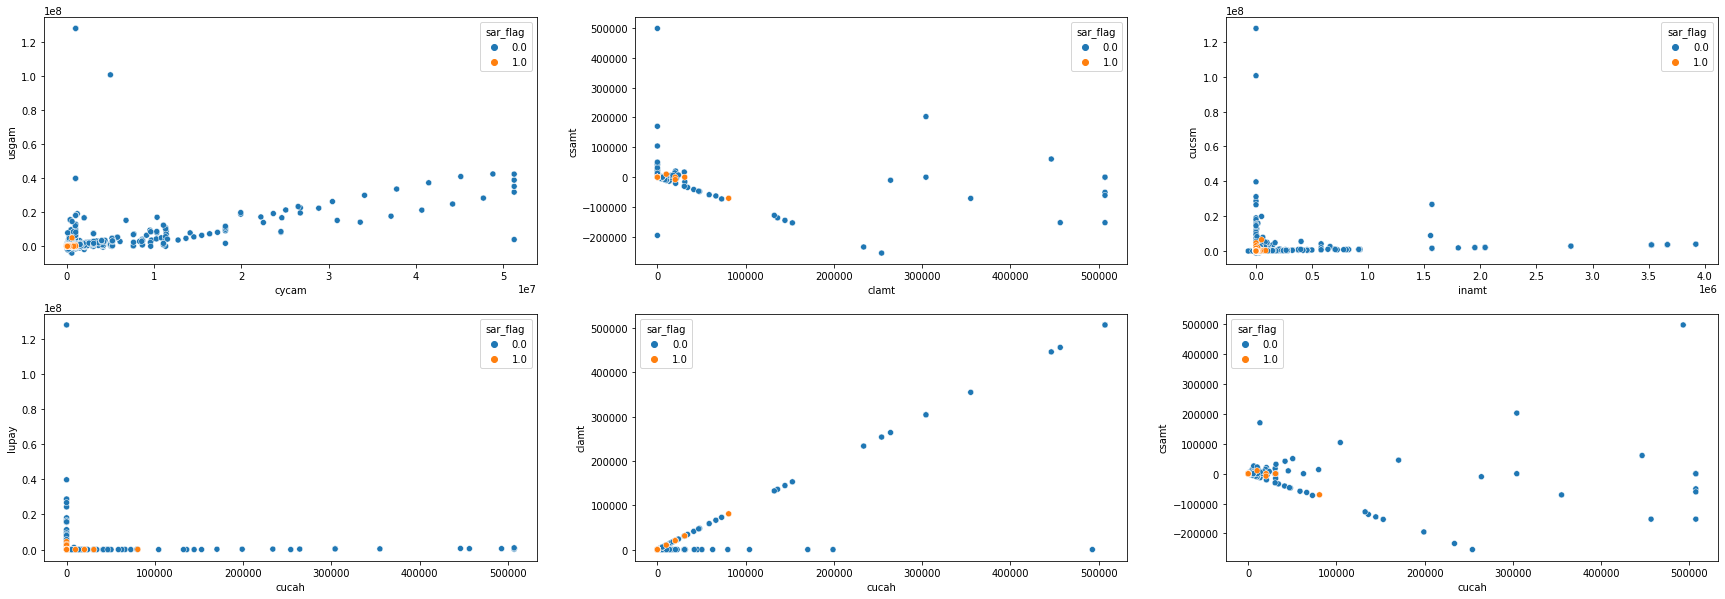

In [26]:
num_col_cp = [['cycam', 'usgam'], ['clamt', 'csamt'], ['inamt', 'cucsm'], ['cucah', 'lupay'], ['cucah', 'clamt'], ['cucah', 'csamt']]

a, b = 2, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.scatterplot(x = num_col_cp[k][0], y = num_col_cp[k][1], hue = target, data = ccba1, ax = ax[i, j])
        k += 1

### cdtx

In [27]:
cdtx = train_g[1].copy()
cdtx = cdtx.drop("source", axis = 1)
null_count = cdtx.isnull().any(axis = 1).sum()
print(f"null: {null_count} / {len(cdtx)} = {round(null_count/len(cdtx), 4)}")
cdtx.head(3)

null: 0 / 486076 = 0.0


,cust_id,date,country,cur_type,amt,sar_flag
0,0,2021-04-26,130,47,1990.0,0.0
1,0,2021-05-12,130,47,5909.0,0.0
2,0,2021-05-26,130,47,1990.0,0.0


In [28]:
target = "sar_flag"
cat_col = ['country', 'cur_type']
num_col = ['amt']
cdtx1 = cdtx.sort_values("sar_flag")

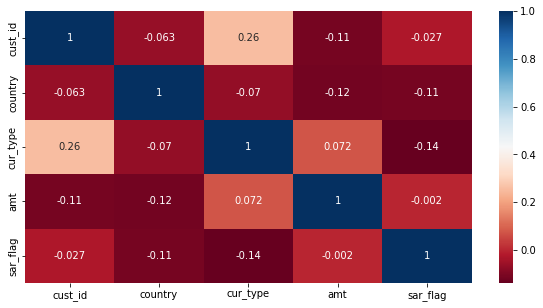

In [29]:
plt.figure(figsize=(10, 5))
corr = cdtx.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

#### Relationship between features & target

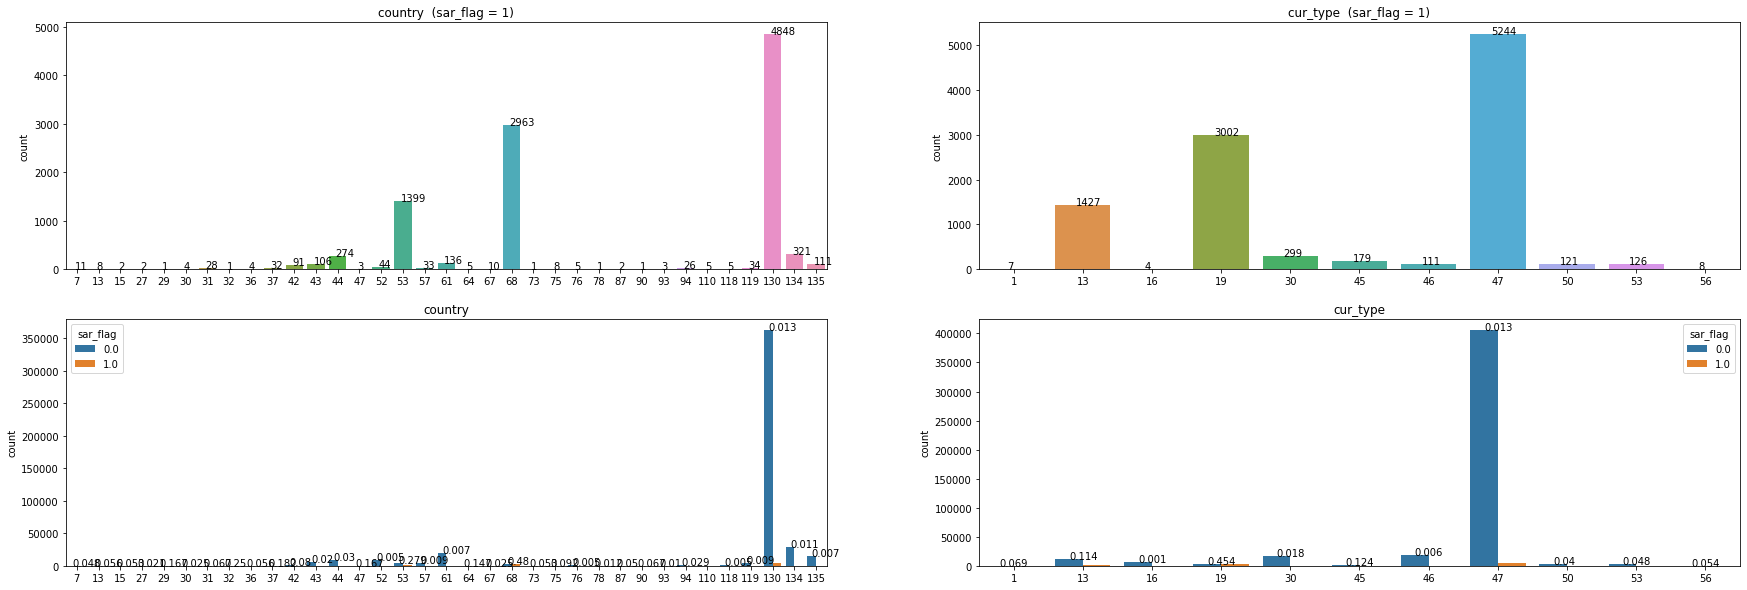

In [30]:
a, b = 2, 2
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for j in range(b):
    col = cat_col[k]
    cdtx1_1 = cdtx1.query(("sar_flag == 1"))
    cats = cdtx1_1[col].unique()
    cdtx1_10 = cdtx1[cdtx1[col].apply(lambda X: X in cats)]


    sns.countplot(x = cat_col[k], data = cdtx1_1, ax = ax[0, j])
    sns.countplot(x = cat_col[k], hue = target, data = cdtx1_10, ax = ax[1, j])

    ax[0, j].set(xlabel = None, title = f"{cat_col[k]}  ({target} = 1)")
    ax[1, j].set(xlabel = None, title = cat_col[k])

    for p in ax[0, j].patches:
        ax[0, j].annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+1), size = 10)
    
    for p in range(0, len(ax[1, j].patches)//2):
        p0 = ax[1, j].patches[p]
        p1 = ax[1, j].patches[p + len(ax[1, j].patches)//2]
        c0 = p0.get_height()
        c1 = p1.get_height()
        prob = round(c1/(c0+c1), 3)
        prob = 0 if pd.isnull(prob) else prob
        ax[1, j].annotate(prob, (p0.get_x()+0.2, p0.get_height()+20), size = 10)

    k += 1

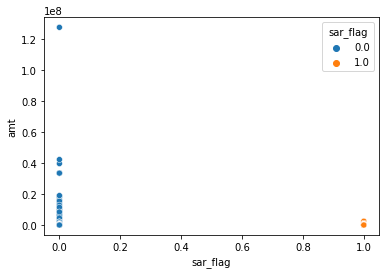

In [31]:
sns.scatterplot(x = target, y = "amt", hue = target, data = cdtx1)
plt.show()
# TODO:洗錢帳戶的信用卡交易金額都不高

### dp

In [32]:
dp = train_g[2].copy()
dp = dp.drop("source", axis = 1)
null_count = dp.isnull().any(axis = 1).sum()
print(f"null: {null_count} / {len(dp)} = {round(null_count/len(dp), 4)}")
dp.isnull().sum()

null: 533044 / 1071814 = 0.4973


cust_id                 0
debit_credit            0
date                    0
tx_type                 0
tx_amt              11148
exchg_rate              0
info_asset_code         0
fiscTxId           527638
txbranch           508128
cross_bank              0
ATM                     0
sar_flag                0
dtype: int64

In [33]:
target = "sar_flag"
cat_col = ['tx_time', "tx_type", "info_asset_code", "fiscTxId", "txbranch", "cross_bank", "ATM"]
num_col = ['tx_amt', "exchg_rate"]
dp1 = dp.sort_values("sar_flag")

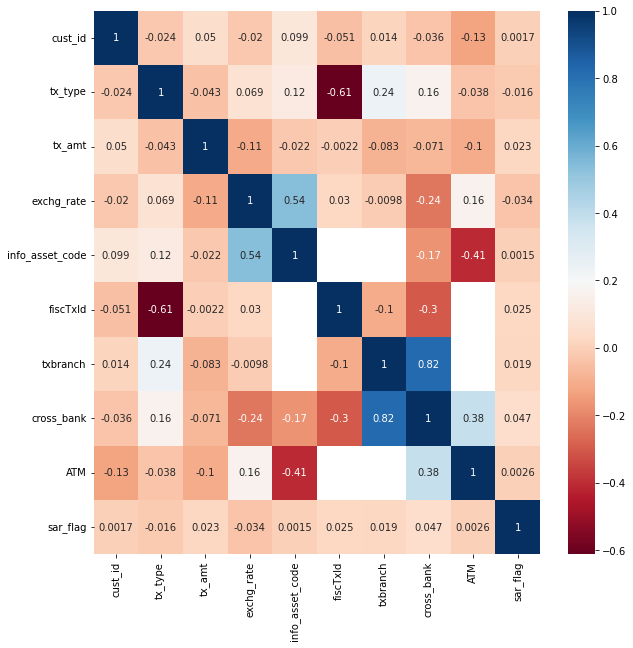

In [34]:
plt.figure(figsize=(10, 10))
corr = dp.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

#### Relationship between features & target

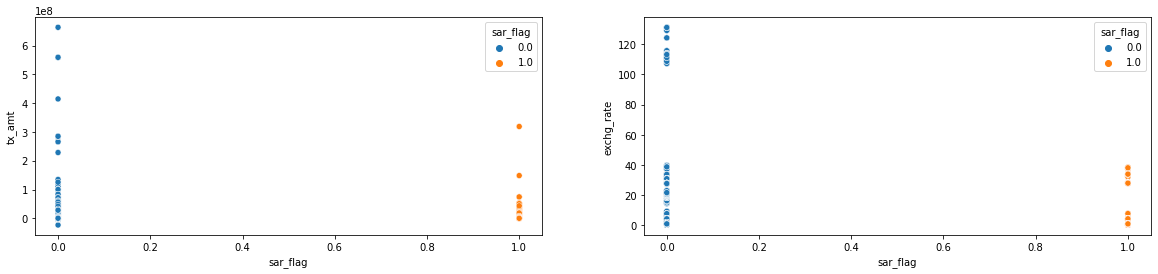

In [35]:
a, b = 1, 2
fig, ax = plt.subplots(a, b, figsize = (20, 4))
for i in range(b):
    sns.scatterplot(x = target, y = num_col[i], hue = target, data = dp1, ax = ax[i])
# TODO:洗錢交易集中在特定匯率下，可能跟國家有關

In [36]:
dp.query("(sar_flag == 1)")["exchg_rate"].describe()

count    60070.000000
mean         2.320027
std          5.789793
min          0.241300
25%          1.000000
50%          1.000000
75%          1.000000
max         38.430000
Name: exchg_rate, dtype: float64

In [43]:
des = dp.describe().T
des["unique"] = dp.nunique()
des

,count,mean,std,min,25%,50%,75%,max,unique
cust_id,1071814.0,3934.266230,2.384758e+03,0.000000e+00,2156.0,4487.0,6073.0,7.263000e+03,5391
tx_type,1071814.0,1.948228,2.422688e-01,1.000000e+00,2.0,2.0,2.0,3.000000e+00,3
tx_amt,1060666.0,134360.967659,1.779795e+06,-2.335789e+07,903.0,3747.0,30112.0,6.635757e+08,154205
exchg_rate,1071814.0,3.597947,7.974049e+00,2.336000e-01,1.0,1.0,1.0,1.311699e+02,2417
info_asset_code,1071814.0,12.512081,5.167875e+00,0.000000e+00,13.0,13.0,16.0,2.100000e+01,22
fiscTxId,544176.0,5.966974,5.163291e+00,0.000000e+00,4.0,4.0,4.0,2.800000e+01,29
txbranch,563686.0,178.372640,1.293547e+02,0.000000e+00,24.0,149.0,310.0,3.700000e+02,317
cross_bank,1071814.0,0.356947,4.790993e-01,0.000000e+00,0.0,0.0,1.0,1.000000e+00,2
ATM,1071814.0,0.789443,4.077045e-01,0.000000e+00,1.0,1.0,1.0,1.000000e+00,2
sar_flag,1071814.0,0.056045,2.300090e-01,0.000000e+00,0.0,0.0,0.0,1.000000e+00,2


In [53]:
cat_col1 = ["tx_type", "cross_bank", "ATM"]

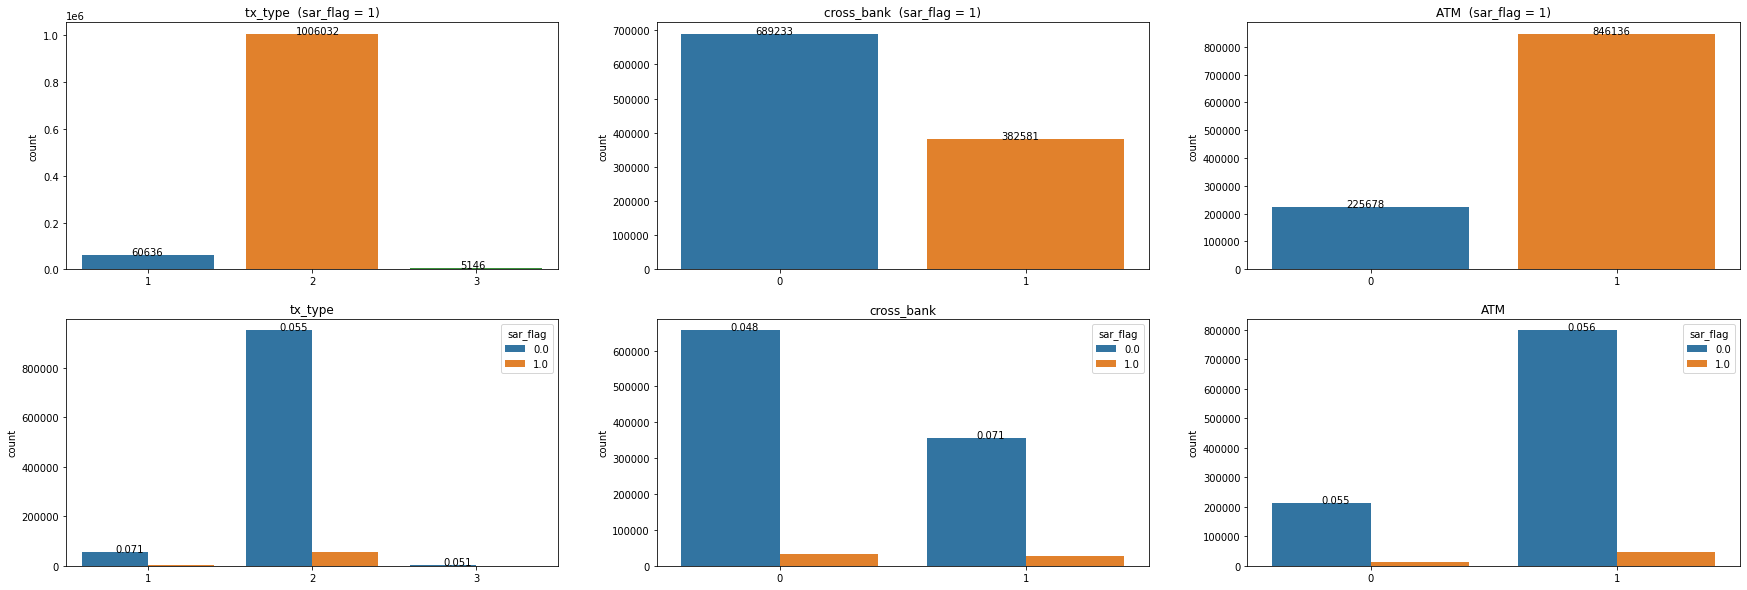

In [54]:
a, b = 2, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for j in range(b):
    sns.countplot(x = cat_col1[k], data = dp1, ax = ax[0, j])
    sns.countplot(x = cat_col1[k], hue = target, data = dp1, ax = ax[1, j])

    ax[0, j].set(xlabel = None, title = f"{cat_col1[k]}  ({target} = 1)")
    ax[1, j].set(xlabel = None, title = cat_col1[k])

    for p in ax[0, j].patches:
        ax[0, j].annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+1), size = 10)
    
    for p in range(0, len(ax[1, j].patches)//2):
        p0 = ax[1, j].patches[p]
        p1 = ax[1, j].patches[p + len(ax[1, j].patches)//2]
        c0 = p0.get_height()
        c1 = p1.get_height()
        prob = round(c1/(c0+c1), 3)
        prob = 0 if pd.isnull(prob) else prob
        ax[1, j].annotate(prob, (p0.get_x()+0.2, p0.get_height()+20), size = 10)

    k += 1

In [59]:
a = 0
b = 0
c = 0
d = 0
for k1, v1 in data.items():# id_
    for k2, v2 in v1.items(): # id_的info sample
        flag_a = 0
        flag_b = 0
        if (v2["data_type"] == "train"):
            for s in v2["data"]: # info sample涵蓋區間的所有資料
                if (s["source"] == 2): # dp 資料
                    if (s["cross_bank"] == 0) & (s["ATM"] == 1):
                        if v2["sar"] == 1:
                            flag_a = 1
                        else:
                            flag_b = 1
        if (v2["data_type"] == "train"):
            a += flag_a
            b += flag_b
            c += v2["sar"]
            d += 1


print(f"cross_bank為0, ATM為1時, sar為1的個數為: {a}")
print(f"cross_bank為0, ATM為1時, sar為1的個數為: {b}")
print(f"sar為1的個數為: {c}")
print(f"總樣本數: {d}")
# TODO:sar為1時，大部分的cross_bank為0, ATM為1

cross_bank為0, ATM為1時, sar為1的個數為: 219
cross_bank為0, ATM為1時, sar為1的個數為: 15086
sar為1的個數為: 234.0
總樣本數: 23906


### remit

In [37]:
remit = train_g[3].copy()
remit = remit.drop("source", axis = 1)
null_count = remit.isnull().any(axis = 1).sum()
print(f"null: {null_count} / {len(remit)} = {round(null_count/len(remit), 4)}")
remit.head(3)

null: 0 / 9819 = 0.0


,cust_id,date,trans_no,trade_amount_usd,sar_flag
0,21,2021-04-01,0,6187.0,0.0
1,21,2021-04-07,0,6221.0,0.0
2,21,2021-04-08,0,3101.0,0.0


In [38]:
target = "sar_flag"
cat_col = ['trans_no']
num_col = ['trade_amount_usd']
remit1 = remit.sort_values("sar_flag")

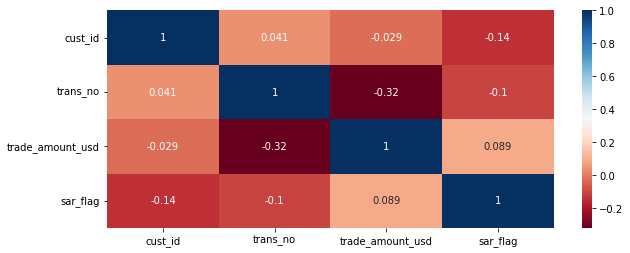

In [39]:
plt.figure(figsize=(10, 4))
corr = remit1.corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

#### Relationship between features & target

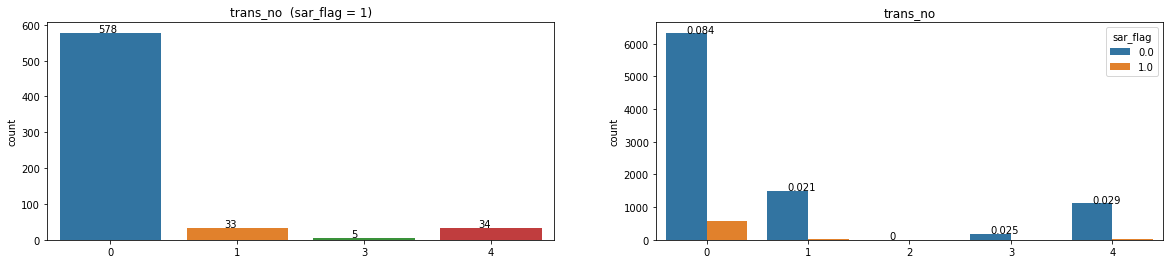

In [40]:
a, b = 1, 2
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 4))
sns.countplot(x = cat_col[k], data = remit1.query("sar_flag == 1"), ax = ax[0])
sns.countplot(x = cat_col[k], hue = target, data = remit1, ax = ax[1])

ax[0].set(xlabel = None, title = f"{cat_col[k]}  ({target} = 1)")
ax[1].set(xlabel = None, title = cat_col[k])

for p in ax[0].patches:
    ax[0].annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+1), size = 10)

for p in range(0, len(ax[1].patches)//2):
    p0 = ax[1].patches[p]
    p1 = ax[1].patches[p + len(ax[1].patches)//2]
    c0 = p0.get_height()
    c1 = p1.get_height()
    prob = round(c1/(c0+c1), 3)
    prob = 0 if pd.isnull(prob) else prob
    ax[1].annotate(prob, (p0.get_x()+0.2, p0.get_height()), size = 10)

    k += 1
# TODO:trans_no的0的犯罪機率較高

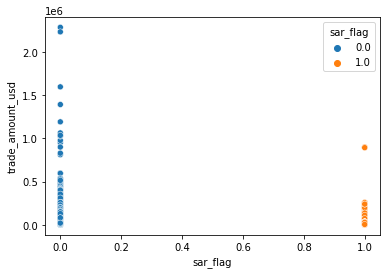

In [41]:
sns.scatterplot(x = target, y = "trade_amount_usd", hue = target, data = remit1)
plt.show()